In [206]:
import sys
from pathlib import Path
import os

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml

if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectorie
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Set the environment variables from the file <root_dir>/.env
from mlfs import config
if os.path.exists(f"{root_dir}/.env"):
    settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: /Users/jarlstephansson/Desktop/ID2223/Lab1-ID2223
HopsworksSettings initialized!


# <span style="font-width:bold; font-size: 3rem; color:#333;">Training Pipeline</span>

## 🗒️ This notebook is divided into the following sections:

1. Select features for the model and create a Feature View with the selected features
2. Create training data using the feature view
3. Train model
4. Evaluate model performance
5. Save model to model registry

### <span style='color:#ff5f27'> 📝 Imports

In [207]:
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, r2_score
import hopsworks
from mlfs.airquality import util
import json

import warnings
warnings.filterwarnings("ignore")

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [ ]:
from dataclasses import dataclass

@dataclass
class Place:
    url: str
    country: str
    city: str
    street: str
    csv: str = None
    lat: str = None   # optional
    lon: str = None   # optional

if settings.HOPSWORKS_API_KEY is not None:
    api_key = settings.HOPSWORKS_API_KEY.get_secret_value()
    os.environ['HOPSWORKS_API_KEY'] = api_key

project = hopsworks.login()
fs = project.get_feature_store() 
secrets = hopsworks.get_secrets_api()


objs = []


for i in range(3):  # we have 3 locations 
    
    # This line will fail if you have not registered the AQICN_API_KEY as a secret in Hopsworks
    AQICN_API_KEY = secrets.get_secret("AQICN_API_KEY").value
    location_str = secrets.get_secret(f"SENSOR_LOCATION_JSON{i}").value
    
    
    location = json.loads(location_str)
    
    country=location['country']
    city=location['city']
    street=location['street']
    aqicn_url=location['aqicn_url']
    latitude=location['latitude']
    longitude=location['longitude']
    temp_obj = Place(
        url=aqicn_url,
        country=country,
        city=city,
        street=street,
        lat=latitude,
        lon=longitude)
    objs.append(temp_obj)


2025-11-18 12:49:14,558 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-11-18 12:49:14,560 INFO: Initializing external client
2025-11-18 12:49:14,561 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-11-18 12:49:15,934 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1272012


In [209]:
# Retrieve feature groups
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)

--- 

## <span style="color:#ff5f27;"> 🖍 Feature View Creation and Retrieving </span>

In [210]:
# Select features for training data.
selected_features = air_quality_fg.select(['pm25', 'date', "rolling1", "rolling2", "rolling3", "city"]).join(weather_fg.select_features(), on=['city'])



2025-11-18 12:49:19,014 INFO: Using ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant'] from feature group `weather` as features for the query. To include primary key and event time use `select_all`.


In [211]:
df_prev = selected_features.read()
df_prev

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.58s) 


,pm25,date,rolling1,rolling2,rolling3,city,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant
0,38.68,2019-12-15 00:00:00+00:00,7.813633,7.816674,7.819832,w 675,1.155250,4.1,11.753876,139.577576
1,14.96,2019-12-29 00:00:00+00:00,38.680000,7.816674,7.819832,w 675,3.532333,0.2,25.567604,238.443802
2,3.20,2020-01-05 00:00:00+00:00,14.960000,38.680000,7.819832,w 675,-0.257250,1.6,18.218275,244.825027
3,3.36,2020-01-06 00:00:00+00:00,3.200000,14.960000,38.680000,w 675,2.894834,0.0,15.856354,239.773376
4,1.60,2020-01-07 00:00:00+00:00,3.360000,3.200000,14.960000,w 675,4.428167,0.1,27.000000,217.152832
...,...,...,...,...,...,...,...,...,...,...
3897,3.92,2025-11-13 00:00:00+00:00,3.720000,3.720000,3.720000,W 911,4.322917,2.5,24.533545,297.223480
3898,4.20,2025-11-14 00:00:00+00:00,3.920000,3.720000,3.720000,W 911,-0.718750,0.0,14.993038,295.483154
3899,3.60,2025-11-15 00:00:00+00:00,4.200000,3.920000,3.720000,W 911,-1.312500,0.0,17.673029,268.015442
3900,4.00,2025-11-16 00:00:00+00:00,3.600000,4.200000,3.920000,W 911,-0.716667,0.0,18.014393,277.304688


### Feature Views

`Feature Views` are selections of features from different **Feature Groups** that make up the input and output API (or schema) for a model. A **Feature Views** can create **Training Data** and also be used in Inference to retrieve inference data.

The Feature Views allows a schema in form of a query with filters, defining a model target feature/label and additional transformation functions (declarative feature encoding).

In order to create Feature View we can use `FeatureStore.get_or_create_feature_view()` method.

You can specify the following parameters:

- `name` - name of a feature group.

- `version` - version of a feature group.

- `labels`- our target variable.

- `transformation_functions` - declarative feature encoding (not used here)

- `query` - selected features/labels for the model 

In [212]:
#! REMOVEEE
feature_view = fs.get_or_create_feature_view(
    name='air_quality_fv',
    description="weather features with air quality as the target",
    version=1,
    labels=['pm25'],
    query=selected_features,
)

Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1272012/fs/1265759/fv/air_quality_fv/version/1


In [213]:
fg_cities = air_quality_fg.read()["city"].unique().tolist()


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.22s) 


In [214]:
def safe_name(x):
    return (
        x.lower()
         .replace(" ", "_")
         .replace("å", "a")
         .replace("ä", "a")
         .replace("ö", "o")
    )

city_fvs = {}


for raw_city in fg_cities:
    cname = safe_name(raw_city)
    print("Creating FV for:", raw_city, "→", cname)

    query = (
        air_quality_fg.select_all()
        .filter(air_quality_fg.city == raw_city)
        .join(weather_fg.select_all(), on=["city"])
    )

    fv = fs.get_or_create_feature_view(
        name=f"air_quality_fv_{cname}",
        description=f"AQI + weather features for {raw_city}",
        version=1,
        labels=["pm25"],
        query=query
    )

    city_fvs[cname] = fv
   

Creating FV for: w 675 → w_675
2025-11-18 12:49:28,315 WARNING: Ambiguous features detected during query construction.The feature `date` is present in feature groups ['air_quality version 1', 'weather version 1']. The feature `city` is present in feature groups ['air_quality version 1', 'weather version 1']. Automatically prefixing features selected using these feature groups with the feature group name.
Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1272012/fs/1265759/fv/air_quality_fv_w_675/version/1
Creating FV for: hedemora → hedemora
2025-11-18 12:49:31,909 WARNING: Ambiguous features detected during query construction.The feature `date` is present in feature groups ['air_quality version 1', 'weather version 1']. The feature `city` is present in feature groups ['air_quality version 1', 'weather version 1']. Automatically prefixing features selected using these feature groups with the feature group name.
Feature view created successfully, explore

## <span style="color:#ff5f27;">🪝 Split the training data into train/test data sets </span>

We use a time-series split here, with training data before this date `start_date_test_data` and test data after this date

In [215]:
city_date_ranges = {}
start_date_val_data = "2024-05-01"
val_start = datetime.strptime(start_date_val_data, "%Y-%m-%d")
# Convert string to datetime object

df_prev = df_prev.sort_values(["city", "date"])


for city, group in df_prev.groupby("city"):
    dates = group["date"].sort_values()

    earliest = dates.min()
    latest = dates.max()

    # number of days in total
    total_days = (latest - earliest).days
    ten_percent_days = int(total_days * 0.10)
    test_start = latest - timedelta(days=ten_percent_days)

    city_date_ranges[city] = {
        "earliest": earliest,
        "latest": latest,
        "validation_start": start_date_val_data,
        "test_start": test_start
    }

city_date_ranges




{'W 911': {'earliest': Timestamp('2025-08-15 00:00:00+0000', tz='Etc/UTC'),
  'latest': Timestamp('2025-11-18 00:00:00+0000', tz='Etc/UTC'),
  'validation_start': '2024-05-01',
  'test_start': Timestamp('2025-11-09 00:00:00+0000', tz='Etc/UTC')},
 'hedemora': {'earliest': Timestamp('2020-01-30 00:00:00+0000', tz='Etc/UTC'),
  'latest': Timestamp('2025-11-18 00:00:00+0000', tz='Etc/UTC'),
  'validation_start': '2024-05-01',
  'test_start': Timestamp('2025-04-21 00:00:00+0000', tz='Etc/UTC')},
 'w 675': {'earliest': Timestamp('2019-12-15 00:00:00+0000', tz='Etc/UTC'),
  'latest': Timestamp('2025-11-18 00:00:00+0000', tz='Etc/UTC'),
  'validation_start': '2024-05-01',
  'test_start': Timestamp('2025-04-16 00:00:00+0000', tz='Etc/UTC')}}

In [216]:
X_train, X_val, X_test, y_train, y_val, y_test = city_fvs["hedemora"].train_validation_test_split(
    test_start=test_start, validation_start=val_start
)


print(f"train: {X_train.shape[0]} test: {X_test.shape[0]} val: {X_val.shape[0]}")

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.58s) 
train: 1463 test: 213 val: 348


In [217]:
X_train.columns

Index(['date', 'city', 'country', 'street', 'url', 'rolling1', 'rolling2',
       'rolling3', 'weather_date', 'weather_temperature_2m_mean',
       'weather_precipitation_sum', 'weather_wind_speed_10m_max',
       'weather_wind_direction_10m_dominant'],
      dtype='object')

In [218]:
def add_month_feat(df):
    df = df.copy()

    # extract month number
    df["month"] = pd.to_datetime(df["date"]).dt.month

    # create OHE with all 12 possible months
    month_ohe = pd.get_dummies(df["month"], prefix="month")

    # ensure all 12 columns exist
    for m in range(1, 13):
        col = f"month_{m}"
        if col not in month_ohe.columns:
            month_ohe[col] = 0

    # order columns 1 → 12
    month_ohe = month_ohe[[f"month_{m}" for m in range(1, 13)]]

    return pd.concat([df, month_ohe], axis=1)
X_train = add_month_feat(X_train)
X_val = add_month_feat(X_val)
X_test = add_month_feat(X_test)

In [219]:
X_features_train = X_train.drop(columns=['date', "month","country", "city", "street", "url", "weather_date"])
X_features_test = X_test.drop(columns=['date', "month","country", "city", "street", "url", "weather_date"])
X_features_val = X_val.drop(columns=['date', "month","country", "city", "street", "url", "weather_date"])

In [220]:
y_train

,pm25
0,6.0
1,9.0
2,13.0
3,4.0
4,36.0
...,...
1458,15.0
1459,13.0
1460,16.0
1461,25.0


The `Feature View` is now saved in Hopsworks and you can retrieve it using `FeatureStore.get_feature_view(name='...', version=1)`.

In [221]:
X_features_train

,rolling1,rolling2,rolling3,weather_temperature_2m_mean,weather_precipitation_sum,weather_wind_speed_10m_max,weather_wind_direction_10m_dominant,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,21.902077,21.907471,21.907425,1.258917,3.200000,8.427383,162.528290,True,False,False,False,False,False,False,False,False,False,False,False
1,6.000000,21.907471,21.907425,1.081833,0.800000,14.003029,136.367477,True,False,False,False,False,False,False,False,False,False,False,False
2,9.000000,6.000000,21.907425,4.596417,4.500000,19.615870,208.201508,False,True,False,False,False,False,False,False,False,False,False,False
3,13.000000,9.000000,6.000000,2.104750,0.600000,21.746502,294.046539,False,True,False,False,False,False,False,False,False,False,False,False
4,4.000000,13.000000,9.000000,-1.674417,0.000000,14.843180,325.217224,False,True,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458,41.000000,26.000000,24.000000,1.848500,6.700001,9.504273,10.092579,False,False,False,True,False,False,False,False,False,False,False,False
1459,15.000000,41.000000,26.000000,2.754750,0.500000,11.165805,142.765106,False,False,False,True,False,False,False,False,False,False,False,False
1460,13.000000,15.000000,41.000000,3.679750,2.100000,13.363711,93.448860,False,False,False,True,False,False,False,False,False,False,False,False
1461,16.000000,13.000000,15.000000,7.611000,5.600000,19.652176,220.502792,False,False,False,True,False,False,False,False,False,False,False,False


---

## <span style="color:#ff5f27;">🧬 Modeling</span>

We will train a regression model to predict pm25 using our 4 features (wind_speed, wind_dir, temp, precipitation)

In [222]:
from sklearn.model_selection import ParameterGrid
from xgboost import XGBRegressor
import itertools


def hyper_param_search(X_train, y_train, X_val, y_val):
    lrs        = [0.3, 0.1, 0.05, 0.01]
    max_depths = [3, 5, 7, 9]
    n_estim    = [200, 500, 1000]
    
    best_score = float("inf")
    best_params = None
    results = []

    for lr, md, ne in itertools.product(lrs, max_depths, n_estim):
        model = XGBRegressor(
            learning_rate=lr,
            max_depth=md,
            n_estimators=ne,
            subsample=1.0,
            colsample_bytree=1.0,
            random_state=42,
        )

        model.fit(X_train, y_train)
        val_pred = model.predict(X_val)
        mse = mean_squared_error(y_val.iloc[:,0], val_pred)

        results.append((mse, lr, md, ne))

        if mse < best_score:
            best_score = mse
            best_params = (lr, md, ne)


    print("\nBest:")
    print(best_params, best_score)
    return best_params, best_score, results


#best_params, best_score, results = hyper_param_search(X_features_train, y_train, X_features_val, y_val)

In [223]:
# Creating an instance of the XGBoost Regressor with HARDCODED params
xgb_regressor = XGBRegressor(learning_rate = 0.1, max_depth = 5, n_estimators=200)
# Fitting the XGBoost Regressor to the training data
xgb_regressor.fit(X_features_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

#### Testing if our feats are good: 

In [224]:
orgs = ["weather_temperature_2m_mean",
    "weather_precipitation_sum",
    "weather_wind_speed_10m_max",
    "weather_wind_direction_10m_dominant"]

X_features_train_org = X_features_train[orgs]
X_features_test_org = X_features_test[orgs]


In [225]:
xgb_regressor_org = XGBRegressor(learning_rate = 0.1, max_depth = 5, n_estimators=200)
xgb_regressor_org.fit(X_features_train_org, y_train)

# Predicting target values on the test set
y_pred_org = xgb_regressor_org.predict(X_features_test_org)

# Calculating Mean Squared Error (MSE) using sklearn
mse = mean_squared_error(y_test.iloc[:,0], y_pred_org)
print("MSE:", mse)

# Calculating R squared using sklearn
r2 = r2_score(y_test.iloc[:,0], y_pred_org)
print("R squared:", r2)


MSE: 131.06306
R squared: -0.13229524353735078


#### The model with our feats

{'w_675': <hsfs.feature_view.FeatureView object at 0x370eae4e0>, 'hedemora': <hsfs.feature_view.FeatureView object at 0x375098740>, 'w_911': <hsfs.feature_view.FeatureView object at 0x375090e60>}
w_911
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.36s) 
2025-11-18 12:58:27,876 INFO: Provenance cached data - overwriting last accessed/created training dataset from 1 to 2.
(86, 13) (9, 13)
MSE: 0.25951105
R squared: -0.6219441852586087


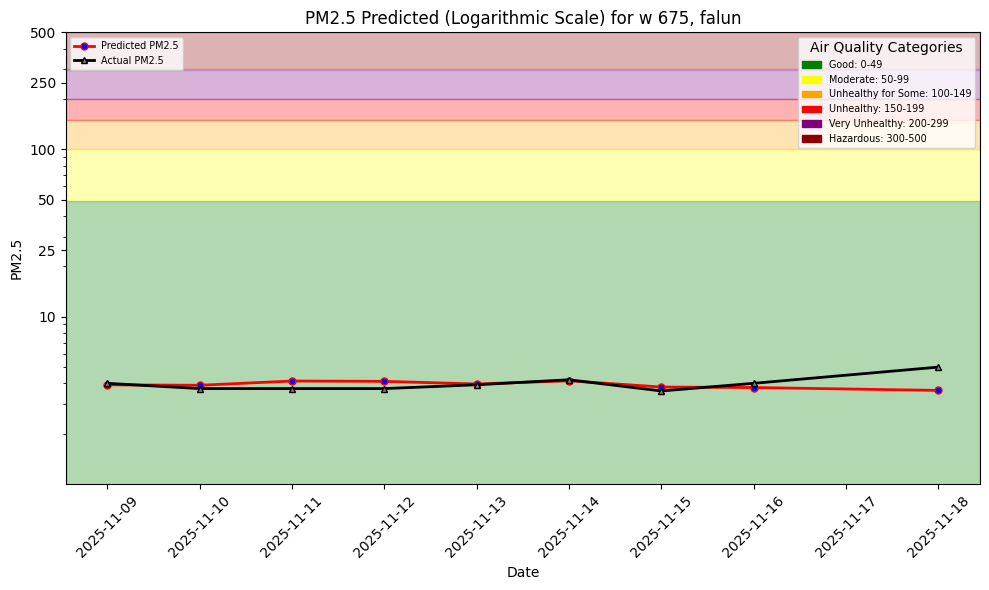

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /Users/jarlstephansson/Desktop/ID2223/Lab1-ID2223/notebooks/airquality/air_quality_model_w_911/model…

Uploading /Users/jarlstephansson/Desktop/ID2223/Lab1-ID2223/notebooks/airquality/air_quality_model_w_911/image…

Uploading /Users/jarlstephansson/Desktop/ID2223/Lab1-ID2223/notebooks/airquality/model_schema.json: 0.000%|   …

Model created, explore it at https://c.app.hopsworks.ai:443/p/1272012/models/air_quality_xgboost_model_w_911/1
hedemora
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.33s) 
2025-11-18 12:58:50,785 INFO: Provenance cached data - overwriting last accessed/created training dataset from 2 to 3.
(1816, 13) (208, 13)
MSE: 54.470234
R squared: 0.5079278893171537


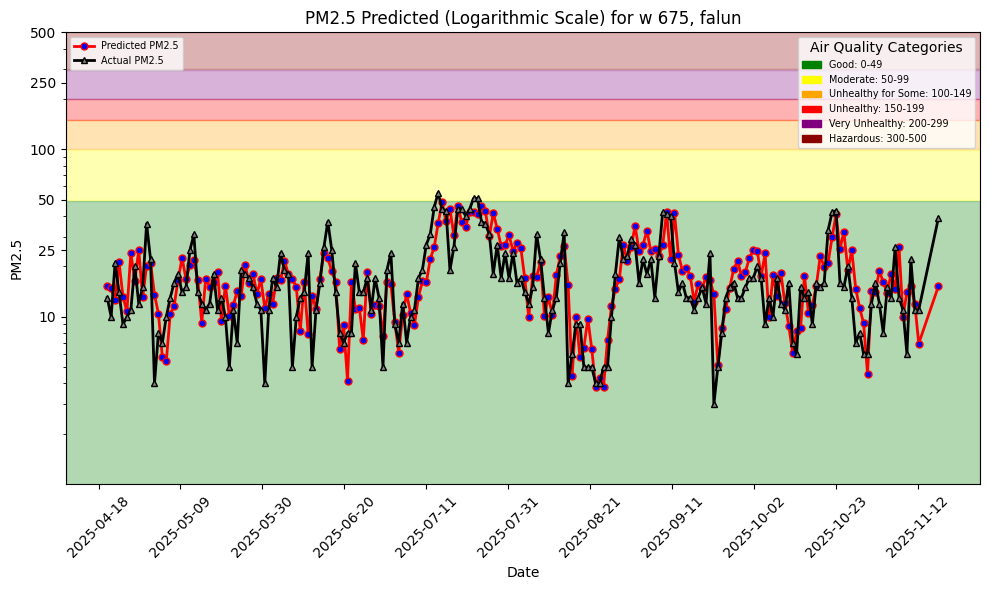

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /Users/jarlstephansson/Desktop/ID2223/Lab1-ID2223/notebooks/airquality/air_quality_model_hedemora/mo…

Uploading /Users/jarlstephansson/Desktop/ID2223/Lab1-ID2223/notebooks/airquality/air_quality_model_hedemora/im…

Uploading /Users/jarlstephansson/Desktop/ID2223/Lab1-ID2223/notebooks/airquality/model_schema.json: 0.000%|   …

Model created, explore it at https://c.app.hopsworks.ai:443/p/1272012/models/air_quality_xgboost_model_hedemora/1
w_675
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.32s) 
2025-11-18 12:59:11,561 INFO: Provenance cached data - overwriting last accessed/created training dataset from 1 to 2.
(1602, 13) (181, 13)
MSE: 40.811275
R squared: 0.31793286706215385


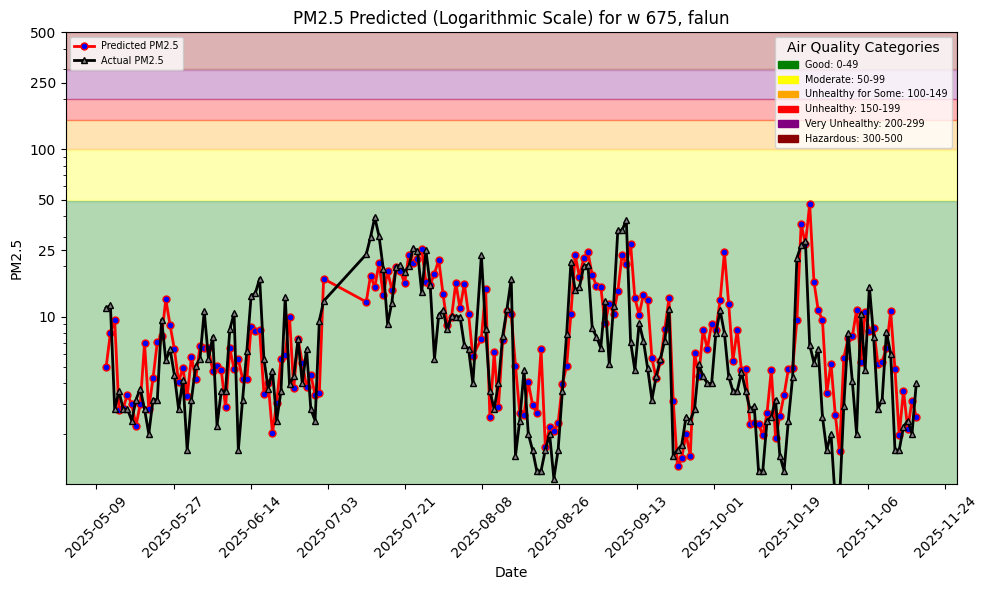

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /Users/jarlstephansson/Desktop/ID2223/Lab1-ID2223/notebooks/airquality/air_quality_model_w_675/model…

Uploading /Users/jarlstephansson/Desktop/ID2223/Lab1-ID2223/notebooks/airquality/air_quality_model_w_675/image…

Uploading /Users/jarlstephansson/Desktop/ID2223/Lab1-ID2223/notebooks/airquality/model_schema.json: 0.000%|   …

Model created, explore it at https://c.app.hopsworks.ai:443/p/1272012/models/air_quality_xgboost_model_w_675/1


In [229]:
# training different models for the different data: 
#safe_name()

print(city_fvs)


for idx, (name, times) in enumerate(city_date_ranges.items()):
    safe_name_t = safe_name(name)
    print(safe_name_t)
    
    temp_test_start = times["test_start"]
    
    X_train, X_test, y_train,y_test = city_fvs[safe_name_t].train_test_split(
    test_start=temp_test_start)
    print(X_train.shape, X_test.shape) # good to see
    X_train = add_month_feat(X_train)
    X_test = add_month_feat(X_test)

    X_features_train = X_train.drop(columns=['date', "month","country", "city", "street", "url", "weather_date"])
    X_features_test = X_test.drop(columns=['date', "month","country", "city", "street", "url", "weather_date"])

    xgb_regressor = XGBRegressor(learning_rate = 0.1, max_depth = 5, n_estimators=200) # from the thingy
    # Fitting the XGBoost Regressor to the training data
    xgb_regressor.fit(X_features_train, y_train)

    # Predicting target values on the test set
    y_pred = xgb_regressor.predict(X_features_test)

    # Calculating Mean Squared Error (MSE) using sklearn
    mse = mean_squared_error(y_test.iloc[:,0], y_pred)
    print("MSE:", mse)

    # Calculating R squared using sklearn
    r2 = r2_score(y_test.iloc[:,0], y_pred)
    print("R squared:", r2)

    df = y_test
    df['predicted_pm25'] = y_pred

    df['date'] = X_test['date']
    df = df.sort_values(by=['date'])

    model_dir = f"air_quality_model_{safe_name_t}"
    if not os.path.exists(model_dir):
        os.mkdir(model_dir)
    images_dir = model_dir + "/images"
    if not os.path.exists(images_dir):
        os.mkdir(images_dir)
    
    file_path = images_dir + "/pm25_hindcast.png"
    plt = util.plot_air_quality_forecast(city, street, df, file_path, hindcast=True) 
    plt.show()
    

    # Saving the XGBoost regressor object as a json file in the model directory
    xgb_regressor.save_model(model_dir + "/model.json")

    res_dict = { 
            "MSE": str(mse),
            "R squared": str(r2),
        }

    mr = project.get_model_registry()

    # Creating a Python model in the model registry named 'air_quality_xgboost_model'

    aq_model = mr.python.create_model(
        name=f"air_quality_xgboost_model_{safe_name_t}", 
        metrics= res_dict,
        feature_view=city_fvs[safe_name_t],
        description="Air Quality (PM2.5) predictor",
    )

    # Saving the model artifacts to the 'air_quality_model' directory in the model registry
    aq_model.save(model_dir)


In [227]:
city_fvs

{'w_675': <hsfs.feature_view.FeatureView at 0x370eae4e0>,
 'hedemora': <hsfs.feature_view.FeatureView at 0x375098740>,
 'w_911': <hsfs.feature_view.FeatureView at 0x375090e60>}

### For 

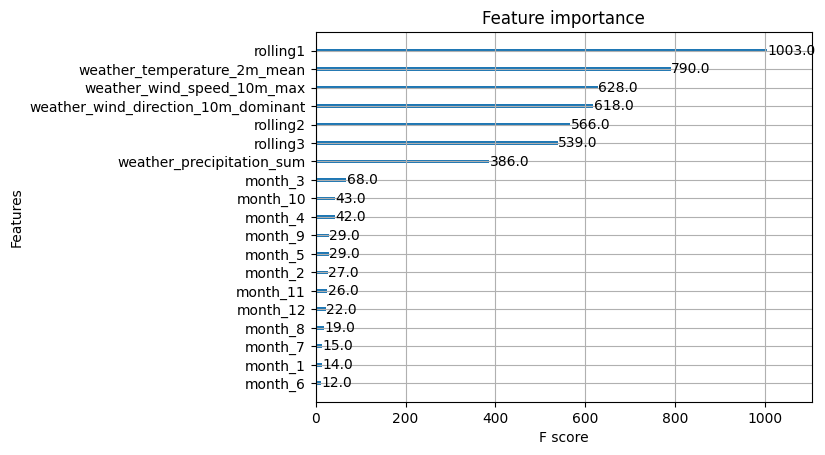

In [ ]:
# Plotting feature importances using the plot_importance function from XGBoost
plot_importance(xgb_regressor)
feature_importance_path = images_dir + "/feature_importance.png"
plt.savefig(feature_importance_path)
plt.show()

---

## <span style='color:#ff5f27'>🗄 Model Registry</span>

One of the features in Hopsworks is the model registry. This is where you can store different versions of models and compare their performance. Models from the registry can then be served as API endpoints.

---
## <span style="color:#ff5f27;">⏭️ **Next:** Part 04: Batch Inference</span>

In the following notebook you will use your model for Batch Inference.
